# GT4Py Concepts

This notebook walks through the major concepts of the [GT4Py](https://github.com/GridTools/gt4py) stencil library. The concepts are exposed with the aid of some illustrative examples which are particularly relevant in weather and climate.

In [22]:
import os
import gt4py.next as gtx
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams["font.size"] = 16

## Defining a stencil computation

Horizontal advection by the mean flow represents a major driving force for atmospheric dynamics. Consider the conserved quantity $\phi = \rho \psi$, where $\rho$ is the air density and $\psi$ a specific quantity. Its transport by the steering wind $(u, \, v)$ is governed by the equation

\begin{equation}
    \frac{\partial \phi}{\partial t} + \frac{\partial u \phi}{\partial x} + \frac{\partial v \phi}{\partial y} = 0 \, .
\end{equation}

(Observe that $\psi \equiv 1$ discloses the continuity equation.) An established way to discretize this equation on a Cartesian grid is by centered spatio-temporal differencing:

\begin{equation}
    \frac{\phi^{n+1}_{i,j} - \phi^{n-1}_{i,j}}{2 \Delta t} + \frac{u_{i+1,j}^n \, \phi_{i+1,j}^n  -  u_{i-1,j}^n \, \phi_{i-1,j}^n}{2 \Delta x} + \frac{v_{i,j+1}^n \, \phi_{i,j+1}^n - v_{i,j-1}^n \, \phi_{i,j-1}^n}{2 \Delta y} = 0 \, .
\end{equation}

This method is commonly known as the leapfrog scheme. Here $\Delta x$ and $\Delta y$ are the grid spacings in the $x$- and $y$-direction, $\Delta t$ is the time-step and for a generic variable $\xi = \xi(x, \, y, \, t)$ we denote by $\xi_{i,j}^n$ the numerical approximation of $\xi(i \Delta x, \, j \Delta y, \, n \Delta t)$. 

![grid](img/grid.png)

The formula which advances the solution forward in time is found to be

\begin{equation}
    \phi_{i,j}^{n+1} = \phi_{i, j}^{n-1} - \frac{\Delta t}{\Delta x} \left( u_{i+1,j}^n \, \phi_{i+1,j}^n - u_{i-1,j}^n \, \phi_{i-1,j}^n \right) - \frac{\Delta t}{\Delta y} \left( v_{i,j+1}^n \, \phi_{i,j+1}^n - v_{i,j-1}^n \, \phi_{i,j-1}^n  \right) \, .
\end{equation}

We recognize the update operator as a stencil computation. The field $\phi^{n+1}$ at $(i, \, j)$ (blue point in the figure below) is computed by accessing $\phi^{n-1}$ at $(i, \, j)$ and $\phi^n$, $u^n$ and $v^n$ at the neignboring points $(i-1, \, j)$, $(i+1, \, j)$, $(i, \, j-1)$ and $(i, \, j+1)$ (red points).

![stencil](img/stencil.png)

GT4Py a domain-specific language (DSL) to express stencil computations as regular Python functions. 

In [23]:
I = gtx.Dimension("I")
J = gtx.Dimension("J")
K = gtx.Dimension("K")

IJKField = gtx.Field[gtx.Dims[I, J, K], gtx.float64]


@gtx.field_operator
def leapfrog(
    u: IJKField,
    v: IJKField,
    phi_old: IJKField,
    phi_now: IJKField,
    dt: gtx.float64,
    dx: gtx.float64,
    dy: gtx.float64,
) -> IJKField:
    dphi_dx = phi_now(I + 1) * u(I + 1) - phi_now(I - 1) * u(I - 1) / (2.0 * dx)
    dphi_dy = phi_now(J + 1) * v(J + 1) - phi_now(J - 1) * v(J - 1) / (2.0 * dy)
    phi_new = phi_old - 2.0 * dt * (dphi_dx + dphi_dy)
               
    return phi_new

Let's dissect the definition function block-by-block.

* All input parameters must be annotated. GT4Py next offers the type descriptor `Field` for data fields. This descriptor is parametric in the data-type. Supported data-types are: `gtx.float64`, which is equivalent to `numpy.float64` in the embedded backend.
* The function adopts an functional interface: its signature includes only read-only fields (`u`, `v`, `phi_old`, `phi_now`) and scalar coefficients (`dt`, `dx`, `dy`), the output is automatically the return value.
* Accessing neighbors is done by shifting the fields with the `field(I + 1)` syntax, where `I` denotes the dimension and `+ 1` an offset in that dimension. Have a look at the figure below for a schematic visualization of how a field with halo is shifted in `J + 1` and `J - 1`.
* Note that for loops are abstracted away and operations are performed for all elements of a field implicitly, similar to NumPy or CuPy. You may think each operation as the body of an `ij`-loop.

![input](img/fieldview_lap_2.png)

#### Note on pure functions:
One instructive view of pure functions is that they cannot have any side effects, for example the call to a `print` function. The following function computes the square of a number `a` and also prints the word "Hello".

In [24]:
def square(a):
    print("Hello")
    return a*a

# Prints Hello twice
b = square(2)
b = square(2)

Hello
Hello


The result of the function is 4, but the side effect is the printing of the "Hello". We say `square` has a side effect. The side effect "Hello" allows us to see if `square(2)` was executed once or twice. We can check the terminal if "Hello" was printed once or twice.

If we remove the print from the function:

In [25]:
def square(a):
    return a*a

# We can no longer tell if there was one or two executions
b = square(2)
b = square(2)

We can no longer say if the function was executed once or twice, except by looking at the code, the result value in b is the same (4) and there is no side effect.
We cann `square(a)` side-effect free, or pure.

Pure functions often appear in scientific computing, since most of our computations are data-in data-out methods without side effects.
Pure functions have some very big upsides, for example, they are very easy to predict in their behavior/effect

## Storages

GT4Py's data storages are fields on structured grids (or unstructured) grids. The following figure shows how the array elements (green boxes) map to the grid points (grey dots). The pairs between square brackets represent the element indices in a horizontal slice of the storage.

![storage](img/storage.png)

Fields in GT4Py are multi-dimensional arrays on a domain with named dimensions. This is implemented by wrapping a NumPy or CuPy array and adding the domain specific operations to the field interface (often just dispatching to the NumPy or CuPy implementation). To access the underlying array you can use `field.ndarray` (CuPy or NumPy array) or `field.asnumpy()` to convert it to NumPy.

The user interface hides as much as possible all low-level and backend-specific details, like the memory layout, strides, padding, etc.. All these aspects are handled internally by GT4Py in a transparent fashion.

In [26]:
# different possible backends
#backend = None             # Embedded, native Python execution
backend = gtx.gtfn_cpu     # Translated to C code
#backend = gtx.gtfn_gpu     # Translated to GPU (CUDA or HIP) code

# defining dimensions
I = gtx.Dimension("I")
J = gtx.Dimension("J")
K = gtx.Dimension("K", kind=gtx.DimensionKind.VERTICAL)

# sizes and origins
field_domain = gtx.domain({
    I: (-1, 513),
    J: (-1, 513),
    K: (0, 128),
})

u = gtx.zeros(field_domain, dtype=gtx.float64, allocator=backend)
v = gtx.ones(field_domain, dtype=gtx.float64, allocator=backend)

In [27]:
from gt4py.next.iterator.embedded import MutableLocatedField

# define helper function enabling random fields
def random_field(
    domain: gtx.Domain, low: float = -1.0, high: float = 1.0, *, allocator=None
) -> MutableLocatedField:
    # return as gt4py field
    return gtx.as_field(
        domain,
        # create numpy/cupy array depending on the allocator
        np.random.default_rng().uniform(low=low, high=high, size=domain.shape),
        allocator=allocator,
    )

In [28]:
# define three random fields
phi_old = random_field(field_domain, allocator=backend)
phi_now = random_field(field_domain, allocator=backend)
phi_new = random_field(field_domain, allocator=backend)

We can use `.asnumpy()` to coerce a GT4Py array into a plain NumPy array. The coercion preserves the memory layout and it is required e.g. when using matplotlib.

In [29]:
# prints the domain of the field
print(phi_old)

# prints the content of phi_old
print(phi_old.asnumpy())

⟨Domain(I[horizontal]=(-1:513), J[horizontal]=(-1:513), K[vertical]=(0:128)) → DType(scalar_type=<class 'numpy.float64'>, tensor_shape=())⟩
[[[-0.47002553 -0.22416821  0.49252683 ... -0.69606203 -0.94674583
    0.7060262 ]
  [ 0.42324556  0.75194675 -0.62577194 ...  0.7729971   0.39414789
    0.90482695]
  [ 0.48292045  0.16753342  0.05977314 ... -0.41481662  0.71120897
    0.60579336]
  ...
  [ 0.52729431 -0.4258012   0.14473726 ...  0.41565805 -0.77576612
   -0.02609883]
  [-0.91697124  0.33228861  0.21831673 ...  0.46798247  0.57217958
   -0.01900374]
  [-0.91980563  0.64166791  0.3471975  ... -0.53987877 -0.06045349
   -0.67327892]]

 [[-0.40236004 -0.87695271 -0.42941724 ... -0.43729305 -0.10432281
    0.57246739]
  [-0.12709652  0.8577126   0.95367815 ... -0.23871164 -0.99482541
    0.8673681 ]
  [ 0.69356257 -0.86208318 -0.70094602 ... -0.60680833  0.38485959
   -0.25019885]
  ...
  [ 0.51181614  0.40773263 -0.06916144 ... -0.59094241  0.11906344
    0.73989754]
  [-0.37485112  

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
    <b>1.</b> Convert a randomly generated <tt>numpy.ndarray</tt> of size <tt>nx x ny x nz = 128 x 128 x 64</tt> and type <tt>numpy.float64</tt> into a GT4Py storage. Name this field <tt>a</tt>. The <tt>strides</tt> attribute of a <tt>numpy.ndarray</tt> and a GT4Py storage returns the memory strides in bytes along each dimension. For each backend try to infer the memory layout from the strides. Do your findings agree with what we have discussed over this week? <br>
    <b>2.</b> The function <tt>plot_slice</tt> tries to visualize <tt>a[:, :, 0]</tt>. Check yourself that the function raises an exception with any backend. How could you make it work? 
</div>

In [30]:
# TODO - create a storage for each of the 3 backends, investigate the domains 

print(field_domain.shape)

a = random_field(field_domain, allocator=None)
print(a)

a = random_field(field_domain, allocator=gtx.gtfn_cpu)
print(a)

#a = random_field(field_domain, allocator=gtx.gtfn_gpu)
#print(a)

(514, 514, 128)
⟨Domain(I[horizontal]=(-1:513), J[horizontal]=(-1:513), K[vertical]=(0:128)) → DType(scalar_type=<class 'numpy.float64'>, tensor_shape=())⟩
⟨Domain(I[horizontal]=(-1:513), J[horizontal]=(-1:513), K[vertical]=(0:128)) → DType(scalar_type=<class 'numpy.float64'>, tensor_shape=())⟩


In [31]:
def plot_slice(field):
    fig, ax = plt.subplots(1, 1)
    # TODO - fix the line below
    im = ax.imshow(field.asnumpy()[:,:,1], origin="lower", vmin=0, vmax=1)
    fig.colorbar(im, cmap="magma", ax=ax)
    ax.set_xticks(range(0, 513, 128))
    ax.set_yticks(range(0, 513, 128))
    plt.show()

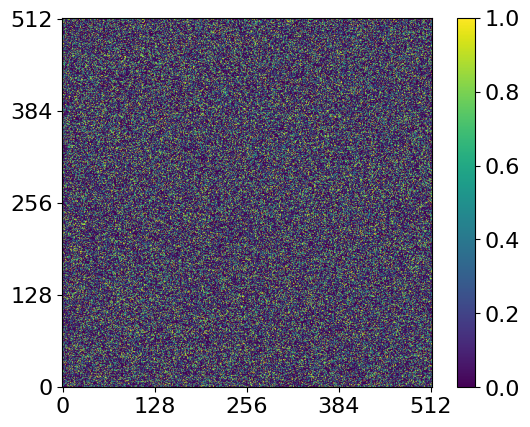

In [32]:
plot_slice(a)

## Running a stencil

GT4Py can generate high-performance implementations of a stencil starting from its definition function. The GT4Py pipeline relies on the [GridTools (GT) framework](https://github.com/GridTools) to produce native implementations for different platforms. The piece of software in charge of synthetizing optimized code for a specific hardware architecture is called **backend**. The default is *no* backend (`backend=None`) which runs the program natively in Python (using NumPy/CuPy under the hood).

In [ ]:
backend = gtx.gtfn_cpu
leapfrog_stencil = leapfrog.with_backend(backend) # creates a program with the given backend

In this course we use the following backends

* `None`: execution directly in Python, natively, using numpy or cupy
* `gtx.gtfn_cpu`: produces C++ GT-based code devised for a generic CPU;
* `gtx.gtfn_gpu`: produces C++ GT-based code for NVIDIA GPUs.

TODO: discuss caching

## Running computations

Executing stencil computations is as simple as a function call:

In [36]:
compute_domain = gtx.domain({
    I: (0, 512),
    J: (0, 512),
    K: (0, 128),
})

leapfrog(
    u=u,
    v=v,
    phi_old=phi_old,
    phi_now=phi_now,
    dt=1.0,
    dx=1.0,
    dy=1.0,
    out=phi_new,
    domain=compute_domain,
)

The stencil object retains the same signature of its definition function and adds two additional parameters: `out` and `domain`. The former specifies where the data should be written to (here `phi_new`) and serves as a non-functional entry point to the DSL `phi_new` for interfacing with surrounding code. The `domain` is the region where we want to compute values for `out`.
TODO: remove origin from the picture and improve domain description

![halo](img/halo.png)

The blue area denotes the computation domain, i.e. where values for `phi_new` can be computed and stored. On the other hand, the red boxes form the **boundary region** where values for `phi_new` cannot be calculated, but where the input fields `u`, `v` and `phi_now` are read. It should be remarked that the figure showcases the *largest* possible computation domain. It is possible to restrict the application of the stencil to a subset of largest feasible computation domain, provided the computation doesn't access areas outside of the domain. In Python execution you will get an error indicating mismatching domains, (currently - to be improved) you might get a segmentation fault / cuda memory error in the compiled backends.

In [35]:
# stencil halo
stencil_extent = (1, 1, 0)

# storage shape
buffer_shape = (nx, ny, nz)

# stencil origin
origin = (1, 1, 0)

# stencil computation domain
domain = (nx - 2, ny - 2, nz)

# requirements
assert all(origin[i] >= stencil_extent[i] for i in range(3))
assert all(origin[i] + domain[i] <= buffer_shape[i] - stencil_extent[i] for i in range(3))

NameError: name 'nx' is not defined

It should also be noted that the binding between the symbols used within the definition function and the storage buffers happens at invocation time. This implies that the stencil object is not bound to any given grid size. Therefore the same stencil computation can be run on different grids and/or computation domains without any re-compilation.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
    <b>3.</b> Run the <tt>leapfrog</tt> stencil with <tt>origin=(0, 0, 0)</tt>. Do the computations run for any domain size? <br>
    <b>4.</b> Write a simple stencil which sets a field equal to $1$. Compile it using the <tt>numpy</tt> backend. Assume then it is fed with a field of size <tt>(128, 128, 64)</tt>, filled with zeros, and it is invoked employing either (i) <tt>origin=(32, 32, 0)</tt> and <tt>domain=(64, 64, 64)</tt>, or (ii) <tt>origin=(64, 0, 0)</tt> and <tt>domain=(64, 128, 64)</tt>. Can you guess which is the result in both cases? Assess the correctness of your ideas using the function <tt>validate_to_one</tt>.
</div>

In [ ]:
def to_one_defs(a: gtscript.Field[float]):
    with computation(PARALLEL), interval(...):
        a = 1.0

In [ ]:
to_one = gtscript.stencil(definition=to_one_defs, backend="numpy")

In [ ]:
def validate_to_one(stencil):
    backend = stencil.backend
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    a = gt.storage.zeros(backend, (0, 0, 0), (128, 128, 64), float)
    stencil(a=a, origin=(32, 32, 0), domain=(64, 64, 64))
    im0 = axs[0].imshow(np.asarray(a[:, :, 0]), origin="lower", vmin=0, vmax=1)
    axs[0].set_title("Case (i)")
    axs[0].set_xlabel("i")
    axs[0].set_xticks(range(0, 129, 32))
    axs[0].set_ylabel("j")
    axs[0].set_yticks(range(0, 129, 32))
    
    a[...] = 0.0
    stencil(a=a, origin=(64, 0, 0), domain=(64, 128, 64))
    im1 = axs[1].imshow(np.asarray(a[:, :, 0]).transpose(), origin="lower", vmin=0, vmax=1)
    fig.colorbar(im1, cmap="magma", ax=[axs[0], axs[1]])
    axs[1].set_title("Case (ii)")
    axs[1].set_xlabel("i")
    axs[1].set_xticks(range(0, 129, 32))
    axs[1].set_yticks(range(0, 129, 32))
    
    plt.show()

In [ ]:
validate_to_one(to_one)

## Functions

GTScript allows the user to call a customed function inside a computation block. This function can accept both fields and scalar coefficients, performs stencil operations, and eventually returns one or multiple fields. One should think of a function as a macro which is automatically expanded by the GT4Py pipeline. So there is little performance penalty associated with functions. This is in contrast with regular Python functions, whose invocation may entail significant overheads. To make a function callable from within a stencil, use the `gtscript.function` decorator.

In [ ]:
@gtx.field_operator
def centered_diff_x(
    u: IJKField,
    phi: IJKField,
    dx: gtx.float64,
) -> IJKField:
    return (phi(I + 1) * u(I + 1) - phi(I - 1) * u(I - 1)) / (2.0 * dx)

@gtx.field_operator
def centered_diff_y(
    v: IJKField,
    phi: IJKField,
    dy: gtx.float64,
) -> IJKField:
    return (phi(J + 1) * v(J + 1) - phi(J - 1) * v(J - 1)) / (2.0 * dy)

@gtx.field_operator
def leapfrog_functions_defs(
    u: IJKField,
    v: IJKField,
    phi_old: IJKField,
    phi_now: IJKField,
    dt: gtx.float64,
    dx: gtx.float64,
    dy: gtx.float64,
) -> IJKField:
    
    dphi_dx = centered_diff_x(u, phi_now, dx)
    dphi_dy = centered_diff_y(v, phi_now, dy)
    phi_new = phi_old - 2.0 * dt * (dphi_dx + dphi_dy)
    
    return phi_new

In [ ]:
leapfrog_stencil = leapfrog.with_backend(backend)

dt=0.1
dx=0.1
dy=0.1

%timeit leapfrog_stencil(u=u, v=v, phi_old=phi_old, phi_now=phi_now, dt=dt, dx=dx, dy=dy, out=phi_new, domain=field_domain, offset_provider={"_IOff": I, "_JOff": J})

%timeit leapfrog_stencil(u=u, v=v, phi_old=phi_old, phi_now=phi_now, dt=dt, dx=dx, dy=dy, out=phi_new, domain=field_domain, offset_provider={"_IOff": I, "_JOff": J})

The systematic use of functions may avoid duplicated code and improve readability, without introducing unacceptable overheads. The latter statement can be easily validated on our simple example:

## Run-time conditionals

GT4Py supports all binary operators (e.g. sum, difference, multiplication, etc) and ternary operators. The latter are also known as conditional expressions in Python, and can be used to calculate the absolute value of a field:

In [ ]:
@gtx.field_operator
def absolute_value_field(phi: gtx.float64):
    return phi if phi > 0.0 else -phi

The ternary operator can also be split into an if-statement followed by an else-statement:

In [ ]:
from gt4py.next import where

@gtx.field_operator
def absolute_value_pointwise(phi: IJKField):
    out = where(
        phi > 0.0,
        phi,
        -phi,
    )

    return out

Another notable example where run-time conditionals come in handy is the numerical integration of the hyperbolic equation

\begin{equation}
    \frac{\partial \phi}{\partial t} + \frac{\partial \phi u}{\partial x} + \frac{\partial \phi v}{\partial y} = 0 \, .
\end{equation}

by the upwind scheme:

\begin{equation}
    F_{i,j} =
    \begin{cases}
        & \left( \phi_{i,j} \, u_{i,j} - \phi_{i-1,j} \, u_{i-1,j} \right) / \Delta x \qquad \text{if $u_{i,j} > 0$} \\
        & \left( \phi_{i+1,j} \, u_{i+1,j} - \phi_{i,j} \, u_{i,j} \right) / \Delta x \qquad \text{if $u_{i,j} <= 0$}
    \end{cases} \\
    G_{i,j} =
    \begin{cases}
        & \left( \phi_{i,j} \, v_{i,j} - \phi_{i,j-1} \, v_{i,j-1} \right) / \Delta y \qquad \text{if $v_{i,j} > 0$} \\
        & \left( \phi_{i,j+1} \, v_{i,j+1} - \phi_{i,j} \, v_{i,j} \right) / \Delta y \qquad \text{if $v_{i,j} <= 0$}
    \end{cases} \\
    \phi_{i,j}^{n+1} = \phi_{i,j}^n - \Delta t \left( F_{i,j}^n + G_{i,j}^n \right) \, .
\end{equation}

In [ ]:
from gt4py.next import where

@gtx.field_operator
def upwind_diff_x(
    u: IJKField,
    phi: IJKField,
    dx: gtx.float64,
) -> IJKField:
    out = where(
        u > 0.0,
        (phi * u - phi(I - 1) * u(I - 1)) / dx,
        (phi(I + 1) * u(I + 1) - phi* u) / dx,
    )
    
    return out

@gtx.field_operator
def upwind_diff_y(
    v: IJKField,
    phi: IJKField,
    dy: gtx.float64,
) -> IJKField:
    out = where(
        v > 0.0,
        (phi * v - phi(J - 1) * v(J -1)) / dy,
        (phi(J + 1) * v(J + 1) - phi * v) / dy,
    )
  
    return out

@gtx.field_operator
def upwind(
    u: IJKField,
    v: IJKField,
    phi_now: IJKField,
    dt: gtx.float64,
    dx: gtx.float64,
    dy: gtx.float64,
) -> IJKField:

    dphi_dx = upwind_diff_x(u, phi_now, dx)
    dphi_dy = upwind_diff_y(v, phi_now, dy)
    phi_new = phi_now - dt * (dphi_dx + dphi_dy)
    
    return phi_new
        
upwind_stencil = upwind.with_backend(backend)

## Compile-time conditionals

A more sophisticated control flow statement consists of an if-else construct which queries a **scalar** quantity whose value is known at the stencil compile-time. Such scalar quantity is made available inside the stencil definition as an external symbol and read through the `__INLINED()` accessor. An example for this could be a configuration option `UPWINDING` which regulates the type of advection scheme to use. This technique allows to fuse the `leapfrog` and `upwind` stencils into a unique stencil.

In [ ]:
@gtx.field_operator
def horizontal_advection_(
    u: IJKField,
    v: IJKField,
    phi_now: IJKField,
    dt: gtx.float64,
    dx: gtx.float64,
    dy: gtx.float64,
    upwinding: bool,
) -> IJKField:
    
    if (upwinding):
        dphi_dx = upwind_diff_x(u, phi_now, dx)
        dphi_dy = upwind_diff_y(v, phi_now, dy)
    else:
        dphi_dx = centered_diff_x(u, phi_now, dx)
        dphi_dy = centered_diff_y(v, phi_now, dy)
            
    phi_new = phi_old - 2.0 * dt * (dphi_dx + dphi_dy)
    
    return phi_new


@gtx.program
def horizontal_advection(
    u: IJKField,
    v: IJKField,
    phi_now: IJKField,
    phi_new: IJKField,
    dt: gtx.float64,
    dx: gtx.float64,
    dy: gtx.float64,
    upwinding: bool,
):
    horizontal_advection_(
        u,
        v,
        phi_now,
        dt,
        dx,
        dy,
        upwinding,
        out=phi_new,
        offset_provider={"_IOff": I, "_JOff": J},
    )

# @HANNES: I cannot get this pre-compilation to work
horizontal_advection_stencil = horizontal_advection.with_backend(backend).compile(upwinding = [True])

## Vertical direction

The atmopshere is strongly anisotropic: its thickness is rather small as compared to the average Earth radius. Plus, in the majority of weather and climate models the vertical grid levels are unevenly distributed. They are packed close to the surface, and stretched out gradually as you move upwards. As a result, the lowest grid cells are much wider than thick. Typically the height of the lowermost cells is in the order of $10$ m, while the horizontal grid spacing is in the order of kilometers. To prevent unduly limitations on the time-step size, vertical advection is often treated implicity. 

Let's consider the prototype equation

\begin{equation}
    \frac{\partial \phi}{\partial t} = \frac{\partial w \phi}{\partial z}
\end{equation}

where $z$ is the geometric height and $w$ is the vertical velocity. We integrate this equation using the Crank-Nicolson scheme coupled with vertical centered differences:

\begin{equation}
    \frac{\phi^{n+1}_k - \phi^n_k}{\Delta t} = \frac{1}{2} \left( \frac{w^n_{k+1} \, \phi^n_{k+1}  - w^n_{k-1} \, \phi^n_{k-1}}{2 \Delta z} + \frac{w^{n+1}_{k+1} \, \phi^{n+1}_{k+1} - w^{n+1}_{k-1} \, \phi^{n+1}_{k-1}}{2 \Delta z} \right) \, .
\end{equation}

Here $\Delta z$ denotes the vertical grid spacing, which we can assume uniform for our aim. If we suppose that $w$ is  known on each grid location at time $n+1$, this procedure yields a tridiagonal system for $\phi^{n+1}$ along each column:

\begin{equation}
    \dfrac{\Delta t}{4 \Delta z} w^{n+1}_{k-1} \, \phi^{n+1}_{k-1} + \phi^{n+1}_k - \dfrac{\Delta t}{4 \Delta z} w^{n+1}_{k+1} \, \phi^{n+1}_{k+1} = \phi^n_k + \dfrac{\Delta t}{4 \Delta z} \left( w^n_{k+1} \, \phi^n_{k+1} - w^n_{k-1} \, \phi^n_{k-1} \right) \, .
\end{equation}

We can write this system in the general form

\begin{equation}
    \begin{cases}
        & \hspace{-0.5cm} b_1 \phi_1^{n+1} + c_1 \phi_2^{n+1} = d_1 \\
        & \hspace{-0.5cm} a_k \phi_{k-1}^{n+1} + b_k \phi_k^{n+1} + c_k \phi_{k+1}^{n+1} = d_k \hspace{0.5cm} \text{for $k = 2, \, \ldots \, , n_z-1$} \\
        & \hspace{-0.5cm} a_{n_z} \phi_{n_z-1}^{n+1} + b_{n_z} \phi_{n_z}^{n+1} = d_{n_z}
    \end{cases} \, ,
\end{equation}

or in matrix notation

\begin{equation}
    \begin{bmatrix}
        & \hspace{-0.5cm} b_1 &    c_1 &        &         &         0 \\
        & \hspace{-0.5cm} a_2 &    b_2 &    c_2 &         &           \\
        & \hspace{-0.5cm}     &    a_3 &    b_3 &  \ddots &           \\
        & \hspace{-0.5cm}     &        & \ddots &  \ddots & c_{n_z-1} \\
        & \hspace{-0.5cm}   0 &        &        & a_{n_z} &   b_{n_z}
    \end{bmatrix}
    \begin{bmatrix}
        & \hspace{-0.5cm} \phi_1^{n+1}     \\
        & \hspace{-0.5cm} \phi_2^{n+1}     \\
        & \hspace{-0.5cm} \vdots           \\
        & \hspace{-0.5cm} \phi_{n_z}^{n+1}
    \end{bmatrix} =
    \begin{bmatrix}
        & \hspace{-0.5cm} d_1      \\
        & \hspace{-0.5cm} d_2      \\
        & \hspace{-0.5cm} \vdots   \\
        & \hspace{-0.5cm} d_{n_z}
    \end{bmatrix} \, .
\end{equation}

We can efficiently solve for $\phi^{n+1}$ using the [Thomas algorithm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm). This algorithm entails two full scans (**sweeps**) of the vertical axis: a forward sweep 

\begin{equation}
    \text{for $k = 2, \, \ldots \, , n_z$:} \hspace{0.5cm}
    \begin{cases}
        & \hspace{-0.5cm} \omega = \frac{a_k}{b_{k-1}} \\
        & \hspace{-0.5cm} b_k = b_k - \omega c_{k-1} \\
        & \hspace{-0.5cm} d_k = d_k - \omega d_{k-1}
    \end{cases}
\end{equation}

followed by a back-substitution step

\begin{equation}
    \phi^{n+1}_{n_z} = \frac{d_{n_z}}{b_{n_z}} \\
    \text{for $k = n_z-1, \, \ldots \, , 1$:} \hspace{0.5cm} \phi^{n+1}_k = \frac{d_k - c_k \phi^{n+1}_{k+1}}{b_k} \, .
\end{equation}

We already mentioned that in a GTScript function all computations must happen inside a computation block. Each computation block may traverse the vertical axis either in a parallel or sequential fashion. In the former cases, the horizontal planes can be visited in any order. This gives the compiler the complete freedom to scan the vertical dimension in the most efficient way. In the latter case, the computation block steps through the vertical levels either forward or backward. The vertical direction of a computation block is specified by the `computation()` context manager. Within a `computation()`, we may need to diversify the stencil calculations depending on whether we are close to the boundary or the inner region of the domain. The range bounds are set through the `interval()` context manager. We can nest multiple `interval()` contexts inside a `computation()` context, provided that the ranges do not overlap and fully cover the vertical axis.

In [ ]:
@gtx.scan_operator(axis=K, forward=True, init=(0.0, 0.0))
def forward_sweep(
    state:tuple[gtx.float64, gtx.float64],
    a: gtx.float64,
    b_prev: gtx.float64,
    c_prev: gtx.float64,
    d_prev: gtx.float64,
):
    w = a / b_prev
    b = state[0] - w * c_prev
    d = state[1] - w * d_prev
     
    return b, d

@gtx.field_operator
def stencil_thomas_forward(
    a: IJKField,
    b: IJKField,
    c: IJKField,
    d: IJKField,
    phi: IJKField,
) -> tuple[IJKField, IJKField]:
        
    b , d = forward_sweep(a, b(K - 1), c(K - 1), d(K - 1))
    
    return b, d

# @HANNES: this init is not possible I think?
@gtx.scan_operator(axis=K, forward=False, init=d/b)
def backward_sweep(
    phi: gtx.float64,
    b: gtx.float64,
    c: gtx.float64,
    d: gtx.float64,
):
    phi = (d - c * phi) / b
    
    return phi

@gtx.field_operator
def stencil_thomas_backward(
    b: IJKField,
    c: IJKField,
    d: IJKField,
) -> IJKField:
 
    phi = backward_sweep(b, c, d)
    
    return phi

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
    <b>5.</b> Write a stencil which fills each vertical column of the input array with <a href="https://en.wikipedia.org/wiki/Fibonacci_number">Fibonacci numbers</a> so that the k-th vertical level contains the k-th element in the Fibonacci sequence. Compile the stencil with the <tt>gtmc</tt> backend, validate it and plot the results. <br>
    <b>6.</b> What happens if the <tt>FORWARD</tt> keyword is replaced by either <tt>BACKWARD</tt> or <tt>PARALLEL</tt>?
</div>

In [ ]:
# TODO - Fibonacci numbers in k-directions

def fibonacci_defs(inout_field: gtscript.Field[float]):
    from __gtscript__ import BACKWARD, FORWARD, PARALLEL, computation, interval
    
    with computation(FORWARD):
        with interval(0, 2):
            inout_field = 1.0
        with interval(2, None):
            inout_field = inout_field[0, 0, -1] + inout_field[0, 0, -2]

fibonacci = gtscript.stencil(definition=fibonacci_defs, backend="gt:cpu_ifirst")

In [ ]:
# TODO - Validate Fibonacci numbers

def validate_fibonacci(stencil):
    backend = stencil.backend
    
    a = gt.storage.zeros(backend, (0, 0, 0), (1, 1, 64), float)
    stencil(a)
    
    if not np.allclose(a[0, 0, :2], 1.0):
        print("Validation failed.")
        return
        
    a_now = 1.0
    a_new = 1.0
    for k in range(2, 64):
        a_old, a_now = a_now, a_new
        a_new = a_now + a_old
        if not np.isclose(a[0, 0, k], a_new):
            print("Validation failed.")
            return
            
    print("Your code is validated!")

validate_fibonacci(fibonacci)

In [ ]:
# TODO - Plot Fibonacci

def plot_fibonacci(stencil):
    backend = stencil.backend
    a = gt.storage.zeros(backend, (0, 0, 0), (1, 1, 64), float)
    stencil(a)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.semilogy(np.arange(64), np.asarray(a).squeeze(), "b.-")
    ax.set_xlabel("k")
    ax.set_ylabel("field[k]")
    
    plt.show()
    
plot_fibonacci(fibonacci)